In [21]:
%load_ext autoreload
%autoreload 2

In [27]:
import torch
from tqdm import tqdm

from dataset import ProteinSmilesDataset
from smiles import AF2SmilesTransformer
from utils import VocSmiles, check_smiles
from trainer import Runner
import os
from torch.utils.data import DataLoader
import time, random
import numpy as np

from rdkit import Chem

## Suppress RDKit warnings
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

dev = torch.device('cuda')
devices = [0]

In [23]:
model_config = {}

trainer = Runner(model_num=360)

## Testing

protein_targets_file = '/home/andrius/git/datasets/MonoamineR_human_65.txt'
with open(protein_targets_file, 'r') as prot_list:
    target_proteins = prot_list.readlines()
    target_proteins = [t.strip('\n').strip() for t in target_proteins]

smiles = []
smiles_dict = {}
for protein in target_proteins:
    p_smiles = trainer.targetted_generation(protein_id=protein, batch_size=10, repeat=10)
    smiles_dict[protein] = p_smiles

['_', 'GO', '#', '(', ')', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '8', '=', 'B', 'C', 'EOS', 'F', 'I', 'L', 'N', 'O', 'P', 'R', 'S', '[B-]', '[C-]', '[C@@H]', '[C@@]', '[C@H]', '[C@]', '[N+]', '[N-]', '[N@+]', '[O-]', '[OH+]', '[S+]', '[S@+]', '[S@@+]', '[SH]', '[Si]', '[n+]', '[nH]', '[s+]', '[te]', '\\', 'c', 'n', 'o', 's']
Dataset: len: 484677
Generating SMILES for P21917
Generating SMILES 10/10

Validating: 74.0/100 of generated SMILES are valid.

Generating SMILES for Q96RJ0
Generating SMILES 10/10

Validating: 92.0/100 of generated SMILES are valid.

Generating SMILES for Q9H3N8
Generating SMILES 10/10

Validating: 72.0/100 of generated SMILES are valid.

Generating SMILES for P21728
Generating SMILES 10/10

Validating: 94.0/100 of generated SMILES are valid.

Generating SMILES for P28222
Generating SMILES 10/10

Validating: 71.0/100 of generated SMILES are valid.

Generating SMILES for P20309
Generating SMILES 10/10

Validating: 72.0/100 of generated SMILES are valid.

In [6]:
print(target_proteins)

['P21917', 'Q96RJ0', 'Q9H3N8', 'P21728', 'P28222', 'P20309', 'P30939', 'Q9IP65', 'Q13639', 'P28221', 'P25021', 'P13945', 'P08908', 'P08588', 'P28223', 'P25100', 'P18089', 'P28335', 'P35462', 'P08913', 'P21918', 'P50406', 'P28566', 'P08912', 'P18825', 'Q9Y5N1', 'P47898', 'P41595', 'P35367', 'P07550', 'P08172', 'P14416', 'P11229', 'P08173', 'P35368', 'P35348']


In [28]:
## This is for writing the generated smiles

data_dir = '/home/andrius/git/datasets/Monoamines'
for protein in target_proteins:
    subdir = os.path.join(data_dir, protein)
    smiles_dir = os.path.join(subdir, 'model_output')
    os.makedirs(smiles_dir, exist_ok=True)
    smiles_out = os.path.join(smiles_dir, 'smiles.txt')
    
    ## Write smiles as text
    smiles = non_duplicate_canonized[protein]
    with open(smiles_out, 'w') as f:
        f.write("\n".join(smiles))
        
    

In [29]:
## Generate images of SMILES

for protein in target_proteins:
    subdir = os.path.join(data_dir, protein)
    smiles_dir = os.path.join(subdir, 'model_output')
    
    smiles = non_duplicate_canonized[protein]
    for i, smile in enumerate(smiles):
        mol = Chem.MolFromSmiles(smile)
        img_path = os.path.join(smiles_dir, f'{i}.png')
        Chem.Draw.MolToImageFile(mol, img_path)
        

In [28]:
### Load smiles
target_proteins = ['P21917', 'Q96RJ0', 'Q9H3N8', 'P21728', 'P28222', 'P20309', 'P30939', 'Q9IP65', 'Q13639', 'P28221', 'P25021', 'P13945', 'P08908', 'P08588', 'P28223', 'P25100', 'P18089', 'P28335', 'P35462', 'P08913', 'P21918', 'P50406', 'P28566', 'P08912', 'P18825', 'Q9Y5N1', 'P47898', 'P41595', 'P35367', 'P07550', 'P08172', 'P14416', 'P11229', 'P08173', 'P35368', 'P35348']

data_dir = '/home/andrius/git/datasets/Monoamines'
non_duplicate_canonized = {}
for protein in target_proteins:
    protein_dir = os.path.join(data_dir, protein)
    with open(os.path.join(protein_dir, 'model_output', 'smiles.txt'), 'r') as f:
        smiles_raw = f.readlines()
    
    smiles = [s.strip('\n') for s in smiles_raw]
    non_duplicate_canonized[protein] = smiles



In [79]:
import matplotlib.pyplot as plt
from PIL import Image
### Collages

for protein in target_proteins:
    smiles = non_duplicate_canonized[protein]
    mols = [Chem.MolFromSmiles(smile) for smile in smiles]
    img = Chem.Draw.MolsToGridImage(mols[:36], molsPerRow=6, subImgSize=(200, 200),returnPNG=False)
    img.save(f'/home/andrius/git/datasets/Monoamines/Summary/{name_dict[protein]}.png')
    

In [29]:

import subprocess
def generate_protein_pdbqt(pid, chain='A'):
    prot_dir = os.path.join(data_dir, pid)
    inputfile = os.path.join(prot_dir, f'{pid}.pdb')
    print(inputfile)
    out_r_pdb = inputfile.replace('.pdb', f'_{chain}_receptor.pdb')
    out_r_pdb = os.path.join(prot_dir, out_r_pdb)
    out_r_pdbqt = out_r_pdb.replace('.pdb', '.pdbqt')
    subprocess.call(f'pdb_selchain -{chain} {inputfile} | pdb_delhetatm | pdb_tidy > {out_r_pdb}', shell=True)
    subprocess.call(f'/home/andrius/resources/ADFRsuite-1.0/bin/prepare_receptor  -r {out_r_pdb} -o {out_r_pdbqt} -A checkhydrogens', shell=True)

In [30]:
proteins = ['P21917', 'P28222', 'Q13639', 'P25021']
generate_protein_pdbqt(protein)
# del trainer

/home/andrius/git/datasets/Monoamines/P35348/P35348.pdb
adding gasteiger charges to peptide


In [31]:
### Generate protein .pdbqt files
for protein in proteins:
    subdir = os.path.join(data_dir, protein)
    generate_protein_pdbqt(protein)
    

/home/andrius/git/datasets/Monoamines/P21917/P21917.pdb
adding gasteiger charges to peptide
/home/andrius/git/datasets/Monoamines/P28222/P28222.pdb
adding gasteiger charges to peptide
/home/andrius/git/datasets/Monoamines/Q13639/Q13639.pdb
adding gasteiger charges to peptide
/home/andrius/git/datasets/Monoamines/P25021/P25021.pdb
adding gasteiger charges to peptide


In [1]:
### Generating molecule pdbqts
data_dir = '/home/andrius/git/datasets/Monoamines'

from meeko import MoleculePreparation

for protein in proteins:
# protein = target_proteins[0]
    
    protein_dir = os.path.join(data_dir, protein)
    dock_dir = os.path.join(protein_dir, 'docking')
    os.makedirs(dock_dir, exist_ok=True)
    
    smiles = non_duplicate_canonized[protein]
    for i, smile in enumerate(smiles):
        try:
            mol = Chem.MolFromSmiles(smile)
            protonated_ligand = Chem.AddHs(mol)
            Chem.AllChem.EmbedMolecule(protonated_ligand)
            preparator = MoleculePreparation() # macrocycles flexible by default since v0.3.0
            preparator.prepare(protonated_ligand)
            # preparator.show_setup()

            output_pdbqt_file = os.path.join(dock_dir, f"ligand_{i}.pdbqt")
            preparator.write_pdbqt_file(output_pdbqt_file)
            # lig_pdbqt = preparator.write_pdbqt_string()
        except:
            pass

        
def smiles_to_pdbqt(smiles, out_dir):
    """ Converts SMILES to .pdbqt files used by Vina"""
    
    molecule_preparation = MoleculePreparation()
    
    for i, smile ion enumerate(smiles):
        
        try:
            mol = Chem.MolFromSmiles(smile)
            protonated_ligand = Chem.addHs(mol)
        except Exception as ex:
            print(ex)
            return None
            
    molecule_preparation.prepare(mol)
    output_pdbqt_
    
            
        
            
            


SyntaxError: invalid syntax (854296988.py, line 32)

In [52]:
# ## Centroid tests
# from rdkit.Chem.rdMolTransforms import ComputeCentroid
# centroid = ComputeCentroid(mol.GetConformer())
# print(f'Computed centroid {centroid.x:.03f}, {centroid.y:.03f}, {centroid.z:.03f}')

Computed centroid 0.000, 0.000, 0.000


In [14]:
import numpy as np
from rdkit.Chem.rdMolTransforms import ComputeCentroid


protein = target_proteins[0]
sdf_path = os.path.join(data_dir, protein, 'nemonapride.sdf')
supplier = Chem.SDMolSupplier(sdf_path)

## Get centroid of binding ligands
n_samples = 1
centroid = np.zeros(3)
print(centroid)
for i in range(n_samples):
    previous_ligand = next(supplier)

    cent = ComputeCentroid(previous_ligand.GetConformer())
    centroid += np.array([float(cent.x), float(cent.y), float(cent.z)]) / n_samples
    print(f'Computed centroid {cent.x:.03f}, {cent.y:.03f}, {cent.z:.03f}')
print(centroid)

[0. 0. 0.]
Computed centroid -17.212, 13.410, -15.356
[-17.21164706  13.40994118 -15.35635294]


In [32]:
centroids = {'P21917': [-2.753, 0.994, -7.633], # 4-dopamine receptor
             'P28222': [-2.248,  5.319, -5.119],  # 5-hydroxytryptamine receptor
             'Q13639': [ 2.634,  6.859, -1.731], # Serotonin 4 (5-HT4) receptor
             'P25021': [-0.789,  0.026, -6.048], # Histamine H2 receptor 
            }

In [35]:
## Generating config files
import os
ligand_id = 0


def generate_vina_config(target_pdbqt, ligand_pdbqt, output_file, ligand_id, centroid, box_size=20):

    content = f"""\
receptor = {target_pdbqt}
ligand = {ligand_pdbqt}
out = {output_file}
center_x = {centroid[0]}
center_y = {centroid[1]}
center_z = {centroid[2]}
size_x = {box_size}
size_y = {box_size}
size_z = {box_size}
thread = 1000"""
    
    filename = os.path.join(data_dir, protein, 'docking', f'{ligand_id}_vina_config.txt')
    with open(filename, 'w') as f:
        f.write(content)
        
    return filename

        
for protein in proteins:
    protein_dir = os.path.join(data_dir, protein)
    target_pdbqt = os.path.join(protein_dir, f'{protein}_A_receptor.pdbqt')
    docking_results = os.path.join(protein_dir, 'docking_results')
    os.makedirs(docking_results, exist_ok=True)
    smiles = non_duplicate_canonized[protein]
    for i, ligand in enumerate(smiles):
        ligand_pdbqt = os.path.join(protein_dir, 'docking', f'ligand_{i}.pdbqt')
        
        output = os.path.join(docking_results, f'{i}.pdbqt')
        config_path = generate_vina_config(target_pdbqt, ligand_pdbqt, output_file=output, ligand_id=i, centroid=centroids[protein])
        dock(config_path, protein, i)

#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                                                               #
# And also the origin AutoDock Vina paper:                      #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, Journal of Computational Chemistry 31 (2010)  #
# 455-461                                                       #
#                                                               #
# DOI 10.1002/jcc.21334                                         #
#         



Parse error on line 29 in file "/home/andrius/git/datasets/Monoamines/P21917/docking/ligand_2.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Using random seed: -1421997543

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.881 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -6.7      0.000      0.000
   2         -5.5      1.664      2.663
   3         -4.5      1.484      2.125
   4         -4.0      2.810     10.834
   5         -3.9      2.674     10.462
Writing output ... done.
Vina-GPU total runtime: 2.003 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerati

Analyzing the binding site ... done.
Using random seed: 1550315662

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 3
Perform docking|================done=================|
GPU monte carlo runtime: 0.241 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -6.2      0.000      0.000
   2         -5.9      4.195      7.718
   3         -5.8      4.835      8.253
   4         -5.5      3.674      7.023
   5         -5.3      2.905      3.991
   6         -5.2      3.340      3.943
   7         -5.0      2.327      2.795
   8         -5.0      2.564      4.012
   9         -4.9      4.561      8.031
Writing output ... done.
Vina-GPU total runtime: 1.445 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                  



Parse error on line 7 in file "/home/andrius/git/datasets/Monoamines/P21917/docking/ligand_13.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


Parse error on line 16 in file "/home/andrius/git/datasets/Monoamines/P21917/docking/ligand_14.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Using random seed: 1668182876

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 4
Perform docking|================done=================|
GPU monte carlo runtime: 0.419 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -6.5      0.000      0.000
   2         -6.2      2.725      3.370
   3         -5.7      4.395      9.028
   4         -5.7      2.217      3.114
   5         -5.0      3.956      9.023
   6         -5.0      2.141      2.763
   7         -4.8      4.680      9.551
   8         -4.6      4.864      9.045
   9         -4.2      3.613      8.841
Writing output ... done.
Vina-GPU total runtime: 1.717 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                 

Perform docking|================done=================|
GPU monte carlo runtime: 1.497 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1          2.9      0.000      0.000
   2          5.6      1.658      2.283
Writing output ... done.
Vina-GPU total runtime: 2.951 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                                                               #
# And also the origin AutoDock Vina paper:                      #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the 

Setting up the scoring function ... done.
Analyzing the binding site ... done.
Using random seed: 66177496

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 10
Perform docking|================done=================|
GPU monte carlo runtime: 4.171 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -1.9      0.000      0.000
   2          0.0      4.975      7.907
   3          0.3      3.749      7.397
   4          0.4      3.956      5.445
Writing output ... done.
Vina-GPU total runtime: 5.576 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and L



Parse error on line 25 in file "/home/andrius/git/datasets/Monoamines/P21917/docking/ligand_25.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Using random seed: -771992558

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.909 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -4.4      0.000      0.000
   2         -3.5      2.729      8.946
   3         -3.3      1.929      3.653
   4         -3.1      1.775      9.341
   5         -3.0      1.554      2.593
   6         -2.9      1.896      9.304
   7         -2.6      2.210      3.989
   8         -2.4      1.855      9.411
   9         -1.5      2.074      9.386
Writing output ... done.
Vina-GPU total runtime: 2.327 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                 



Parse error on line 38 in file "/home/andrius/git/datasets/Monoamines/P21917/docking/ligand_29.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Analyzing the binding site ... done.
Using random seed: 1420090600

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 3
Perform docking|================done=================|
GPU monte carlo runtime: 0.346 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -7.2      0.000      0.000
   2         -5.6      3.032      4.724
   3         -5.5      3.026      7.607
   4         -5.4      3.048      7.963
   5         -5.0      3.310      8.200
   6         -5.0      1.545      2.276
   7         -4.8      4.044      8.830
   8         -4.8      2.166      3.655
   9         -4.4      4.155      8.945
Writing output ... done.
Vina-GPU total runtime: 1.643 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#            

Analyzing the binding site ... done.
Using random seed: -1520992274

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.776 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -8.2      0.000      0.000
   2         -7.8      3.168      9.698
   3         -7.1      1.500      2.200
   4         -7.1      2.504      3.538
   5         -6.9      1.923      3.045
   6         -6.8      2.445      3.649
   7         -6.3      2.385      3.313
   8         -5.9      2.562      3.723
   9         -5.8      2.502      8.805
Writing output ... done.
Vina-GPU total runtime: 2.113 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                 



Parse error on line 16 in file "/home/andrius/git/datasets/Monoamines/P21917/docking/ligand_41.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Setting up the scoring function ... done.
Analyzing the binding site ... done.
Using random seed: 1347928825

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 2
Perform docking|================done=================|
GPU monte carlo runtime: 0.139 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -5.9      0.000      0.000
   2         -5.7      3.333      7.216
   3         -5.3      1.615      2.553
   4         -5.2      3.154      4.529
   5         -5.2      3.584      7.428
   6         -4.9      3.332      6.918
   7         -4.9      2.392      3.220
   8         -3.8      2.555      4.390
Writing output ... done.
Vina-GPU total runtime: 1.399 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#          

Analyzing the binding site ... done.
Using random seed: -622406827

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.753 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -8.1      0.000      0.000
   2         -8.0      2.101      2.752
   3         -7.2      2.995      4.009
   4         -7.2      3.307      8.695
   5         -6.9      1.682      2.306
   6         -6.9      1.817      2.487
   7         -6.7      4.363      9.252
   8         -6.6      2.312      2.798
   9         -6.6      4.152      9.198
Writing output ... done.
Vina-GPU total runtime: 2.282 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                  


Perform docking|=======                              |
Perform docking|================done=================|
GPU monte carlo runtime: 0.196 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -6.5      0.000      0.000
   2         -6.3      2.666      8.413
   3         -6.3      2.411      8.218
   4         -6.1      1.956      2.681
   5         -5.9      1.440      2.404
   6         -5.8      2.155      3.514
   7         -5.2      2.564      8.371
Writing output ... done.
Vina-GPU total runtime: 1.411 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. 



Parse error on line 24 in file "/home/andrius/git/datasets/Monoamines/P21917/docking/ligand_52.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Using random seed: -1901480008

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.799 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -6.1      0.000      0.000
   2         -5.4      2.780     10.355
   3         -4.6      1.859      2.710
   4         -3.5      2.610     10.496
Writing output ... done.
Vina-GPU total runtime: 2.027 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (20

Analyzing the binding site ... done.
Using random seed: 423092950

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.812 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -6.4      0.000      0.000
   2         -6.1      3.876      9.378
   3         -4.4      1.625      2.221
   4         -4.2      3.919      9.368
   5         -3.6      1.532      2.277
Writing output ... done.
Vina-GPU total runtime: 2.138 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Lin

Analyzing the binding site ... done.
Using random seed: -870430112

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 3
Perform docking|================done=================|
GPU monte carlo runtime: 0.268 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -8.6      0.000      0.000
   2         -7.7      3.564      9.227
   3         -7.6      1.145      2.049
   4         -7.5      3.644      9.154
   5         -6.9      1.591      2.702
Writing output ... done.
Vina-GPU total runtime: 1.527 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Li



Parse error on line 20 in file "/home/andrius/git/datasets/Monoamines/P21917/docking/ligand_67.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Using random seed: 1557287294

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.881 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -8.8      0.000      0.000
   2         -8.4      1.595      2.546
   3         -6.6      2.599      4.215
   4         -6.4      4.173      9.947
   5         -5.8      4.192     10.455
Writing output ... done.
Vina-GPU total runtime: 2.185 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Acceleratin



Parse error on line 37 in file "/home/andrius/git/datasets/Monoamines/P21917/docking/ligand_71.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Using random seed: -1928262114

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 9
Perform docking|================done=================|
GPU monte carlo runtime: 2.726 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -2.8      0.000      0.000
   2         -2.1      2.063      4.456
   3         -1.0      2.802      9.241
   4         -0.9      2.527      7.678
Writing output ... done.
Vina-GPU total runtime: 3.870 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (20



Parse error on line 52 in file "/home/andrius/git/datasets/Monoamines/P28222/docking/ligand_0.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Using random seed: -971908161

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.752 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -7.7      0.000      0.000
   2         -7.3      1.551      2.374
Writing output ... done.
Vina-GPU total runtime: 2.077 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                                                               #


Analyzing the binding site ... done.
Using random seed: 381993768

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 3
Perform docking|================done=================|
GPU monte carlo runtime: 0.193 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -7.1      0.000      0.000
   2         -7.0      0.624      2.595
   3         -6.4      1.303      2.799
   4         -6.4      2.487      5.831
   5         -6.4      2.496      5.370
   6         -6.1      2.584      5.855
   7         -6.0      2.908      4.652
   8         -5.9      2.533      6.363
   9         -5.8      1.159      3.459
Writing output ... done.
Vina-GPU total runtime: 1.294 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                   



Parse error on line 17 in file "/home/andrius/git/datasets/Monoamines/P28222/docking/ligand_11.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


Parse error on line 36 in file "/home/andrius/git/datasets/Monoamines/P28222/docking/ligand_12.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Analyzing the binding site ... done.
Using random seed: 2133194160

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.642 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -3.5      0.000      0.000
   2         -2.5      3.614      9.778
   3         -1.5      3.432      9.774
Writing output ... done.
Vina-GPU total runtime: 1.965 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).

Analyzing the binding site ... done.
Using random seed: -395930606

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 3
Perform docking|================done=================|
GPU monte carlo runtime: 0.221 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -8.7      0.000      0.000
Writing output ... done.
Vina-GPU total runtime: 1.422 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                                                               #
# And als

Setting up the scoring function ... done.
Analyzing the binding site ... done.
Using random seed: -1674828570

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 2
Perform docking|================done=================|
GPU monte carlo runtime: 0.105 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -6.6      0.000      0.000
   2         -6.5      0.639      2.338
   3         -6.0      2.081      3.397
   4         -6.0      1.994      3.226
   5         -5.7      2.480      6.409
   6         -5.6      2.085      5.733
   7         -5.6      2.501      6.368
   8         -5.0      1.970      5.787
   9         -5.0      2.056      5.509
Writing output ... done.
Vina-GPU total runtime: 1.183 s
#################################################################
# If you used Vina-GPU in your work, pleas

Analyzing the binding site ... done.
Using random seed: -320949272

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.775 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -7.8      0.000      0.000
   2         -5.8      1.905      2.845
Writing output ... done.
Vina-GPU total runtime: 2.110 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                                  

Analyzing the binding site ... done.
Using random seed: 2003673633

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.956 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -3.0      0.000      0.000
Writing output ... done.
Vina-GPU total runtime: 2.299 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                                                               #
# And als



Parse error on line 16 in file "/home/andrius/git/datasets/Monoamines/P28222/docking/ligand_36.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Analyzing the binding site ... done.
Using random seed: 2121746117

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 4
Perform docking|================done=================|
GPU monte carlo runtime: 0.359 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -6.8      0.000      0.000
   2         -6.8      2.624      4.594
   3         -6.5      3.105      7.616
   4         -5.3      2.987      6.262
   5         -5.3      2.713      6.930
   6         -5.1      2.939      4.980
   7         -5.0      3.031      7.120
   8         -4.9      2.788      4.136
Writing output ... done.
Vina-GPU total runtime: 1.746 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                    



Parse error on line 54 in file "/home/andrius/git/datasets/Monoamines/P28222/docking/ligand_38.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


Parse error on line 25 in file "/home/andrius/git/datasets/Monoamines/P28222/docking/ligand_39.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


Parse error on line 45 in file "/home/andrius/git/datasets/Monoamines/P28222/docking/ligand_40.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Setting up the scoring function ... done.
Analyzing the binding site ... done.
Using random seed: 33266992

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 7
Perform docking|================done=================|
GPU monte carlo runtime: 1.963 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1          9.6      0.000      0.000
Writing output ... done.
Vina-GPU total runtime: 3.392 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                            



Parse error on line 35 in file "/home/andrius/git/datasets/Monoamines/P28222/docking/ligand_42.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Setting up the scoring function ... done.
Analyzing the binding site ... done.
Using random seed: -804956072

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 6
Perform docking|================done=================|
GPU monte carlo runtime: 1.062 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -5.7      0.000      0.000
   2         -5.6      1.850      3.083
   3         -5.5      1.769      2.575
   4         -5.2      1.659      3.164
   5         -5.1      3.694      8.633
   6         -4.1      1.645      3.135
Writing output ... done.
Vina-GPU total runtime: 2.463 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi,



Parse error on line 31 in file "/home/andrius/git/datasets/Monoamines/P28222/docking/ligand_44.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Setting up the scoring function ... done.
Analyzing the binding site ... done.
Using random seed: -1643211029

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.923 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -4.5      0.000      0.000
   2         -3.9      1.968      3.548
   3         -3.1      1.007      2.662
Writing output ... done.
Vina-GPU total runtime: 2.328 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Acceleratin



Parse error on line 48 in file "/home/andrius/git/datasets/Monoamines/P28222/docking/ligand_46.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Setting up the scoring function ... done.
Analyzing the binding site ... done.
Using random seed: 1813501400

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 6
Perform docking|================done=================|
GPU monte carlo runtime: 1.557 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -1.1      0.000      0.000
Writing output ... done.
Vina-GPU total runtime: 3.069 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                          



Parse error on line 8 in file "/home/andrius/git/datasets/Monoamines/P28222/docking/ligand_50.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Setting up the scoring function ... done.
Analyzing the binding site ... done.
Using random seed: 269542972

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.700 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -8.1      0.000      0.000
   2         -5.9      1.873      3.938
   3         -5.5      2.793      7.499
   4         -5.5      3.093      8.216
Writing output ... done.
Vina-GPU total runtime: 2.139 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng,

Analyzing the binding site ... done.
Using random seed: -1009504448

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 8
Perform docking|================done=================|
GPU monte carlo runtime: 2.670 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         16.6      0.000      0.000
   2         17.1      4.107      7.997
   3         18.0      3.543      7.203
   4         18.1      4.565      7.528
   5         18.2      1.457      2.794
   6         18.8      2.261      3.945
   7         19.0      4.679      8.056
Writing output ... done.
Vina-GPU total runtime: 3.936 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Me



Parse error on line 35 in file "/home/andrius/git/datasets/Monoamines/P28222/docking/ligand_59.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Using random seed: 1741474303

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 6
Perform docking|================done=================|
GPU monte carlo runtime: 1.155 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -5.5      0.000      0.000
Writing output ... done.
Vina-GPU total runtime: 2.429 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                                                               #
# And also the origin AutoDock Vina pape

Analyzing the binding site ... done.
Using random seed: -1199699476

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 2
Perform docking|================done=================|
GPU monte carlo runtime: 0.116 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -7.1      0.000      0.000
   2         -6.6      1.342      3.675
   3         -6.5      2.963      6.024
   4         -6.4      1.543      2.048
   5         -6.1      1.636      3.810
   6         -5.5      2.254      5.193
   7         -5.4      3.068      6.606
Writing output ... done.
Vina-GPU total runtime: 1.405 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Me

Analyzing the binding site ... done.
Using random seed: 1816386368

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 6
Perform docking|================done=================|
GPU monte carlo runtime: 1.380 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1          2.0      0.000      0.000
   2          3.1      1.943      4.544
   3          3.3      1.469      1.986
Writing output ... done.
Vina-GPU total runtime: 2.607 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.



Error: could not open "/home/andrius/git/datasets/Monoamines/Q13639/docking/ligand_1.pdbqt" for reading.


done.
Using random seed: -2081116451

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 7
Perform docking|================done=================|
GPU monte carlo runtime: 1.811 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -4.2      0.000      0.000
   2         -4.1      2.669      4.212
   3         -3.8      2.514     11.310
   4         -3.6      3.678     11.335
   5         -3.2      4.335     10.674
   6         -2.5      4.032     11.391
   7         -2.2      3.394     11.679
   8         -2.1      6.738      9.322
   9         -1.9      3.347     11.000
Writing output ... done.
Vina-GPU total runtime: 3.334 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                



Error: could not open "/home/andrius/git/datasets/Monoamines/Q13639/docking/ligand_7.pdbqt" for reading.


done.
Using random seed: -727156551

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.757 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -3.9      0.000      0.000
   2         -3.6      3.139      4.855
   3         -3.6      5.138     10.507
   4         -3.3      1.830      2.349
   5         -2.9      3.474      5.382
   6         -2.8      5.400     10.208
   7         -2.8      2.307      3.397
   8         -2.8      4.604      9.954
   9         -2.6      6.962     11.726
Writing output ... done.
Vina-GPU total runtime: 2.044 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                 



Parse error on line 39 in file "/home/andrius/git/datasets/Monoamines/Q13639/docking/ligand_12.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Using random seed: -476456764

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 2
Perform docking|================done=================|
GPU monte carlo runtime: 0.158 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -3.8      0.000      0.000
   2         -3.3      2.496      3.982
   3         -3.3      2.038      2.417
   4         -3.3      3.706      6.208
   5         -3.2      2.636      3.711
   6         -3.1      3.841      6.033
   7         -3.1      2.659      3.931
   8         -3.0      6.681     10.157
   9         -3.0      4.412      6.194
Writing output ... done.
Vina-GPU total runtime: 1.319 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                 

Perform docking|================done=================|
GPU monte carlo runtime: 0.106 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -4.2      0.000      0.000
   2         -4.0      3.057      4.905
   3         -4.0      3.198      4.065
   4         -4.0      1.922      5.194
   5         -3.8      9.811     12.967
   6         -3.8      3.517      5.899
   7         -3.7      2.126      3.825
   8         -3.7      8.168     10.427
   9         -3.7      2.679      5.931
Writing output ... done.
Vina-GPU total runtime: 1.204 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating A



Parse error on line 39 in file "/home/andrius/git/datasets/Monoamines/Q13639/docking/ligand_22.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


Parse error on line 31 in file "/home/andrius/git/datasets/Monoamines/Q13639/docking/ligand_23.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Using random seed: -1092949004

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 6
Perform docking|================done=================|
GPU monte carlo runtime: 1.147 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -4.1      0.000      0.000
   2         -3.9      2.029     10.257
   3         -3.2      3.220      9.691
   4         -3.1      2.755     10.662
   5         -3.0      1.785      2.530
   6         -3.0      2.640      3.758
   7         -2.4      2.441      3.426
   8         -2.2      2.689     11.107
   9         -1.8      2.345      2.951
Writing output ... done.
Vina-GPU total runtime: 2.318 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                



Parse error on line 27 in file "/home/andrius/git/datasets/Monoamines/Q13639/docking/ligand_28.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


Parse error on line 30 in file "/home/andrius/git/datasets/Monoamines/Q13639/docking/ligand_29.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Analyzing the binding site ... done.
Using random seed: 819885348

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 3
Perform docking|================done=================|
GPU monte carlo runtime: 0.282 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -4.7      0.000      0.000
   2         -4.6      8.317     10.207
   3         -4.5      9.862     11.895
   4         -4.3      9.315     11.350
   5         -4.3      3.329      4.916
   6         -4.2      7.770      9.719
   7         -4.1      3.304      5.331
   8         -4.1      9.989     11.833
   9         -4.0      8.907     10.824
Writing output ... done.
Vina-GPU total runtime: 1.554 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#             

Analyzing the binding site ... done.
Using random seed: 644280976

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 12
Perform docking|================done=================|
GPU monte carlo runtime: 7.102 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1          0.2      0.000      0.000
Writing output ... done.
Vina-GPU total runtime: 8.762 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                                                               #
# And als

Analyzing the binding site ... done.
Using random seed: -1605193266

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.894 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -4.2      0.000      0.000
   2         -4.0      2.338     10.066
   3         -3.7      1.406      2.805
   4         -3.5      2.248      3.498
   5         -3.5      2.213     10.193
   6         -3.5      1.772      2.434
   7         -3.4      3.897     10.678
   8         -3.2      1.891     10.125
   9         -2.9      4.222      6.694
Writing output ... done.
Vina-GPU total runtime: 2.066 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                 

Perform docking|================done=================|
GPU monte carlo runtime: 1.360 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -3.4      0.000      0.000
   2         -3.4      2.550     10.894
   3         -3.1      2.714     11.038
   4         -3.0      5.302      9.253
   5         -3.0      3.604     10.571
   6         -2.5      2.309      3.300
   7         -2.3      6.875      9.875
   8         -2.2      2.776      3.613
   9         -1.7      3.263      4.195
Writing output ... done.
Vina-GPU total runtime: 2.619 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating A

Analyzing the binding site ... done.
Using random seed: -720597553

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 4
Perform docking|================done=================|
GPU monte carlo runtime: 0.310 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -2.8      0.000      0.000
   2         -2.7      1.828      2.823
   3         -2.6      1.778      4.043
   4         -2.3      2.203      5.014
   5         -2.3      2.502      5.033
   6         -2.3      1.917      3.890
   7         -2.3      2.107      3.713
   8         -2.3      2.142      3.522
   9         -2.3      1.927      3.834
Writing output ... done.
Vina-GPU total runtime: 1.397 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                  

Analyzing the binding site ... done.
Using random seed: -337422940

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 10
Perform docking|================done=================|
GPU monte carlo runtime: 4.383 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -3.2      0.000      0.000
   2         -2.7      3.630     11.492
Writing output ... done.
Vina-GPU total runtime: 5.756 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                                 



Parse error on line 39 in file "/home/andrius/git/datasets/Monoamines/Q13639/docking/ligand_61.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Using random seed: 751542541

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 4
Perform docking|================done=================|
GPU monte carlo runtime: 0.602 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -4.6      0.000      0.000
   2         -4.2      2.043      3.259
   3         -4.0      1.986      3.395
   4         -4.0      2.149      2.726
   5         -3.9      1.789      3.423
   6         -3.9      9.342     12.497
   7         -3.8      7.859     11.271
   8         -3.7      9.242     11.638
   9         -3.5      2.138      2.744
Writing output ... done.
Vina-GPU total runtime: 1.868 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                  



Parse error on line 31 in file "/home/andrius/git/datasets/Monoamines/Q13639/docking/ligand_66.pdbqt": ATOM syntax incorrect: "CG1" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Using random seed: -1630608759

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.819 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1          5.1      0.000      0.000
   2          7.5      4.698     11.183
Writing output ... done.
Vina-GPU total runtime: 2.392 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                                                               #



Parse error on line 26 in file "/home/andrius/git/datasets/Monoamines/P25021/docking/ligand_1.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Setting up the scoring function ... done.
Analyzing the binding site ... done.
Using random seed: 1826111104

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 2
Perform docking|================done=================|
GPU monte carlo runtime: 0.231 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1          4.9      0.000      0.000
   2          5.4      2.053      5.598
   3          6.0      2.747      6.769
   4          6.3      2.477      4.314
   5          7.2      2.410      4.197
   6          7.8      2.328      6.000
Writing output ... done.
Vina-GPU total runtime: 1.570 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi,



Parse error on line 34 in file "/home/andrius/git/datasets/Monoamines/P25021/docking/ligand_6.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Using random seed: 414635084

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 6
Perform docking|================done=================|
GPU monte carlo runtime: 1.199 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1          7.9      0.000      0.000
   2         10.7      3.077      4.964
Writing output ... done.
Vina-GPU total runtime: 2.429 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                                                               #
#



Parse error on line 40 in file "/home/andrius/git/datasets/Monoamines/P25021/docking/ligand_10.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Using random seed: -158592937

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 3
Perform docking|================done=================|
GPU monte carlo runtime: 0.327 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -1.0      0.000      0.000
   2          0.6      1.762      2.476
   3          1.0      2.344      7.775
   4          1.1      2.462      3.676
   5          1.5      1.803      7.377
Writing output ... done.
Vina-GPU total runtime: 1.627 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Acceleratin

Reading input ... done.
Setting up the scoring function ... done.
Analyzing the binding site ... done.
Using random seed: 1195463317

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.837 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1          2.9      0.000      0.000
   2          5.8      1.416      2.650
Writing output ... done.
Vina-GPU total runtime: 2.274 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GP

Analyzing the binding site ... done.
Using random seed: -1745445277

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 8
Perform docking|================done=================|
GPU monte carlo runtime: 2.437 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1          7.4      0.000      0.000
Writing output ... done.
Vina-GPU total runtime: 3.793 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                                                               #
# And al



Parse error on line 21 in file "/home/andrius/git/datasets/Monoamines/P25021/docking/ligand_25.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Setting up the scoring function ... done.
Analyzing the binding site ... done.
Using random seed: 1138152097

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.759 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -1.1      0.000      0.000
   2         -0.8      1.802      9.825
   3          0.1      1.712      2.320
Writing output ... done.
Vina-GPU total runtime: 2.009 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating

Analyzing the binding site ... done.
Using random seed: 271053076

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 3
Perform docking|================done=================|
GPU monte carlo runtime: 0.341 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1          0.6      0.000      0.000
   2          2.1      2.578      8.646
   3          3.1      3.046      8.713
   4          3.2      2.564      8.744
   5          3.5      1.333      2.585
Writing output ... done.
Vina-GPU total runtime: 1.515 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Lin



Parse error on line 63 in file "/home/andrius/git/datasets/Monoamines/P25021/docking/ligand_36.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                                                               #
# And also the origin AutoDock Vina paper:                      #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, Journal of Computational Chemistry 31 (2010)  #
# 455-461                                                       #
#                                                               #
# DOI 10.1002/jcc.21334                                         #
#         

Analyzing the binding site ... done.
Using random seed: 904741384

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 7
Perform docking|================done=================|
GPU monte carlo runtime: 1.464 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1          2.3      0.000      0.000
Writing output ... done.
Vina-GPU total runtime: 2.888 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                                                               #
# And also



Parse error on line 15 in file "/home/andrius/git/datasets/Monoamines/P25021/docking/ligand_45.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                                                               #
# And also the origin AutoDock Vina paper:                      #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, Journal of Computational Chemistry 31 (2010)  #
# 455-461                                                       #
#                                                               #
# DOI 10.1002/jcc.21334                                         #
#         

Analyzing the binding site ... done.
Using random seed: 714818320

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 5
Perform docking|================done=================|
GPU monte carlo runtime: 0.820 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1          4.2      0.000      0.000
Writing output ... done.
Vina-GPU total runtime: 2.142 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                                                               #
# And also



Parse error on line 34 in file "/home/andrius/git/datasets/Monoamines/P25021/docking/ligand_54.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Using random seed: -1946763248

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 8
Perform docking|================done=================|
GPU monte carlo runtime: 2.321 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         13.4      0.000      0.000
Writing output ... done.
Vina-GPU total runtime: 3.843 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print.   #
#                                                               #
# And also the origin AutoDock Vina pap

Analyzing the binding site ... done.
Using random seed: -1563393100

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 8
Perform docking|================done=================|
GPU monte carlo runtime: 2.271 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         11.5      0.000      0.000
   2         12.4      4.887      9.873
   3         14.2      2.177      4.232
Writing output ... done.
Vina-GPU total runtime: 3.734 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Accelerating AutoDock VINA with GPUs. ChemRxiv (2021).Print



Parse error on line 12 in file "/home/andrius/git/datasets/Monoamines/P25021/docking/ligand_63.pdbqt": ATOM syntax incorrect: "CG0" is not a valid AutoDock type. Note that AutoDock atom types are case-sensitive.


done.
Using random seed: 1878977722

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 6
Perform docking|================done=================|
GPU monte carlo runtime: 0.942 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1          0.2      0.000      0.000
   2          0.6      1.426      2.791
   3          1.9      4.156      8.751
   4          2.5      1.706      2.494
   5          2.7      4.414      9.427
Writing output ... done.
Vina-GPU total runtime: 2.349 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Mengru, Lin Qingde,               #
#Zhu Yanxiang, Wu Jiansheng, Hu Haifeng, and Ling Ming.         #
#Acceleratin

Analyzing the binding site ... done.
Using random seed: -91376075

Platform: NVIDIA CUDA
Device: NVIDIA GeForce RTX 2060

Build kernels from source
OpenCL version: 3.0
Search depth is set to 2
Perform docking|================done=================|
GPU monte carlo runtime: 0.180 s
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         -1.3      0.000      0.000
   2         -0.6      3.249      8.368
   3          0.3      1.747      3.562
   4          0.4      1.538      1.999
   5          0.9      3.378      7.923
   6          1.1      3.462      7.747
   7          1.1      2.081      3.419
Writing output ... done.
Vina-GPU total runtime: 1.294 s
#################################################################
# If you used Vina-GPU in your work, please cite:               #
#                                                               #
#Shidi, Tang, Chen Ruiqi, Lin Meng

In [34]:
import subprocess
protein = 'P21917'
from subprocess import Popen
import os 
from os import environ


env = dict(os.environ)
env['LD_LIBRARY_PATH'] = '/usr/local/lib:/usr/local/boost/lib'
os.environ['LD_LIBRARY_PATH'] = '/usr/local/lib:/usr/local/boost/lib'

def dock(config, protein, ligand_id):
    log = f' --log /home/andrius/git/datasets/Monoamines/{protein}/docking_results/{ligand_id}.log'
    subprocess.call(f'./Vina-GPU --config /home/andrius/git/datasets/Monoamines/{protein}/docking/{ligand_id}_vina_config.txt'+log, shell=True, cwd='/home/andrius/git/Vina-GPU')

# This part is for inspecting the characteristics of generated smiles

In [25]:
## Check VALIDITY

def validate(smiles):
    
    valid = []
    scores = check_smiles(smiles)
    for i, smile in enumerate(smiles):
        if scores[i] == 1:
            valid.append(smile)
    
    return valid


valid = {}

for protein in target_proteins:
    valid[protein] = validate(smiles_dict[protein])

valid_percentages = [len(valid[p])/len(smiles_dict[p]) for p in target_proteins]

print(valid)
print(valid_percentages)      

{'P21917': ['O/N=C(\\CCCN1CCN(c2cccc(F)c2)CC1)c1ccccc1', 'CCCN(CCNC)S(=O)(=O)c1ccc(C(=O)NC(C)(C)C)cc1', 'Fc1ccccc1CN1CCN(CCOc2ccnc3ccccc23)CC1', 'CC(C)c1c[nH]c(=O)n(Cc2cc(Cl)ccc2)c1=O', 'O=C1CN(Cc2ccccc2)CCN1Cc1ccc(F)cc1', 'COc1c2ccccc2cc2c1ccc(CN1CCN(c3ccccc3)CC1)c2OC', 'Cc1nn(CCCCNC(=O)c2ccc(COCc3c(Cl)cccc3)cc2)cc1', 'CCCN(CCCCN1CCN(c2c(Cl)c(Cl)ccc2)CC1)c1ccccc1', 'CC(=O)c1c(CN(C)C)cc(OCCCCN2CCN(c3ccc(C(F)(F)F)cc3)CC2)cc1', 'Cc1ccc(C(=O)NCCCN2CCN(c3c(Cl)c(Cl)ccc3)CC2)cc1', 'Nc1nc(NNC(=O)c2ccc(F)cc2Cl)nn1Cc1ccccc1Cl', 'Cc1ccc(N2CCN(Cc3ccc4sc(=O)n(C)c(=O)c4c3C)CC2)cc1[N+](=O)[O-]', 'C/C(CCCCCO)=N/N=C/c1ccc(Cl)cc1', 'CN1CCN(CCC2=Cc3c(cccc3)Cc3ccccc23)CC1', 'Cc1ccc(CN2CCN(c3cccc[n+]3[O-])CC2)cc1', 'Cc1c(-c2ccccc2)nc(O)n1C1CCN(Cc2cccc(C(=O)Oc3ccccc3)c2)CC1', 'O=C(COC(=O)c1cc(Cl)ccc1)NC1CCN(Cc2ccccc2)CC1', 'O=C1NCc2c1ccc(CN1CCC(c3ccccc3)CC1)c2', 'O=C(NCC1CCN(Cc2ccc(F)cc2)CC1)c1ccc(O)c2c1cccc2', 'CCC1(CCO)CNC(=O)N=C(N)N1c1cccc(C)c1', 'COc1c(CN2CCN(c3ncc(Cl)cc3)CC2)cc(Br)c2c1cccc2', 'Cn1ccc2

In [26]:
## Checking for duplicates (identical SMILES)

non_duplicate = {}
for p in target_proteins:
    smiles_list = valid[p]
    non_dupes = list(set(smiles_list))
    non_duplicate[p] = non_dupes
    print(p, len(smiles_list), len(non_dupes), len(smiles_list) - len(non_dupes))


P21917 74 74 0
Q96RJ0 92 92 0
Q9H3N8 72 72 0
P21728 94 94 0
P28222 71 71 0
P20309 72 72 0
P30939 74 74 0
Q9IP65 85 85 0
Q13639 67 67 0
P28221 69 69 0
P25021 74 74 0
P13945 74 74 0
P08908 90 90 0
P08588 80 80 0
P28223 68 68 0
P25100 69 69 0
P18089 53 53 0
P28335 66 66 0
P35462 92 92 0
P08913 67 67 0
P21918 84 84 0
P50406 57 57 0
P28566 86 86 0
P08912 96 96 0
P18825 59 59 0
Q9Y5N1 69 69 0
P47898 92 92 0
P41595 59 59 0
P35367 62 62 0
P07550 92 92 0
P08172 66 66 0
P14416 88 88 0
P11229 94 94 0
P08173 92 92 0
P35368 76 76 0
P35348 76 76 0


In [27]:
## Canonize to check how many of the generated molecules are unique

non_duplicate_canonized = {}
for p in target_proteins:
    smiles_list = non_duplicate[p]
    canonized = [Chem.CanonSmiles(smile) for smile in smiles_list]
    canonized_non_dupes = list(set(canonized))
    non_duplicate_canonized[p] = canonized_non_dupes
    print(p, len(smiles_list), len(canonized_non_dupes), len(smiles_list) - len(canonized_non_dupes))
    
n_canonized_non_dupes = [len(non_duplicate_canonized[p]) for p in target_proteins]

P21917 74 74 0
Q96RJ0 92 92 0
Q9H3N8 72 72 0
P21728 94 94 0
P28222 71 71 0
P20309 72 72 0
P30939 74 74 0
Q9IP65 85 85 0
Q13639 67 67 0
P28221 69 69 0
P25021 74 74 0
P13945 74 74 0
P08908 90 90 0
P08588 80 80 0
P28223 68 68 0
P25100 69 69 0
P18089 53 53 0
P28335 66 66 0
P35462 92 92 0
P08913 67 67 0
P21918 84 84 0
P50406 57 57 0
P28566 86 86 0
P08912 96 96 0
P18825 59 59 0
Q9Y5N1 69 69 0
P47898 92 92 0
P41595 59 59 0
P35367 62 62 0
P07550 92 92 0
P08172 66 66 0
P14416 88 88 0
P11229 94 94 0
P08173 92 92 0
P35368 76 76 0
P35348 76 76 0


In [29]:
## Load the dataset
from trainer import load_dataset, load_voc
from config import DatasetConfig

config = DatasetConfig()
voc = load_voc(config)

dataset = load_dataset(voc, config)

['_', 'GO', '#', '(', ')', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '8', '=', 'B', 'C', 'EOS', 'F', 'I', 'L', 'N', 'O', 'P', 'R', 'S', '[B-]', '[C-]', '[C@@H]', '[C@@]', '[C@H]', '[C@]', '[N+]', '[N-]', '[N@+]', '[O-]', '[OH+]', '[S+]', '[S@+]', '[S@@+]', '[SH]', '[Si]', '[n+]', '[nH]', '[s+]', '[te]', '\\', 'c', 'n', 'o', 's']
Dataset: len: 484677


In [93]:
# Isolate smiles based on protein id

from utils import standardize_mol

protein_smiles_dict = {}
all_smiles = []
for line in dataset.tsv_dataset:
    pid, pchembl, smiles = line.split('\t')
    tokens = smiles.split(' ')[:-1]
    joined = ''.join(tokens)

    if protein_smiles_dict.get(pid) is not None:
        protein_smiles_dict[pid] += [joined]
    else:
        protein_smiles_dict[pid] = [joined]
        
    all_smiles += [joined]

all_smiles = list(set(all_smiles))

all_smiles_canonized = []
for smile in all_smiles:
    res = check_smiles([smile])
    if res[0][0] != 0:
        canonized = Chem.CanonSmiles(smile)
        all_smiles_canonized += [canonized]
        
        
print(len(all_smiles), len(all_smiles_canonized))

76493 56823


In [136]:
## Check whether generated smiles overlap with the dataset

all_set = set(all_smiles_canonized)
differences = []

for i, protein in enumerate(target_proteins):
    intersect = set(non_duplicate_canonized[protein]).intersection(all_set)
    difference = set(non_duplicate_canonized[protein]).difference(all_set)
    differences += [len(list(difference))]
    print(protein, 
          len(list(intersect)),
          len(list(difference)), round(mean_l[i], 2), min_l[i], max_l[i],
          num_datapoints[i])


P21917 13 360 40.61 9 70 1775
Q96RJ0 58 411 31.31 16 64 47897
Q9H3N8 12 339 38.38 14 70 730
P21728 52 405 31.67 15 57 45289
P28222 9 290 44.97 19 74 775
P20309 15 310 48.96 17 93 1412
P30939 12 350 40.74 7 76 95
Q9IP65 27 394 34.45 14 76 0
Q13639 3 301 48.38 22 98 526
P28221 21 299 44.7 13 83 968
P25021 4 348 43.77 20 77 88
P13945 1 395 53.93 19 97 1355
P08908 43 381 33.52 16 71 13872
P08588 1 395 48.24 18 84 763
P28223 16 353 45.16 3 72 3048
P25100 18 324 47.43 15 88 1210
P18089 6 322 40.77 17 78 294
P28335 9 334 41.9 17 83 1989
P35462 58 397 32.33 16 65 52417
P08913 9 302 40.76 17 78 568
P21918 31 389 34.24 18 77 157
P50406 10 287 43.76 14 73 2572
P28566 67 383 30.46 2 53 10542
P08912 64 394 31.37 16 58 48429
P18825 9 323 40.51 12 81 480
Q9Y5N1 2 348 41.82 17 79 3276
P47898 67 391 31.42 14 51 45848
P41595 7 323 40.3 20 85 992
P35367 3 313 44.34 19 83 842
P07550 54 405 31.3 17 69 48276
P08172 11 335 44.29 20 85 1063
P14416 62 392 32.53 4 70 46590
P11229 71 390 31.53 5 64 49040
P08173 

In [215]:
## Find average length of generated smiles:
mean_l = []
max_l = []
min_l = []

for p in target_proteins:
    lengths = [len(smile) for smile in non_duplicate_canonized[p]]
    mean = np.mean(lengths)
    min_l += [min(lengths)]
    max_l += [max(lengths)]
    mean_l += [mean]
    print(p, mean)

print(target_proteins)
## Find the number of datapoints per protein

data_mean_l = []
target_proteins.remove('Q9IP65')
for p in target_proteins:
    lengths = [len(smile) for smile in protein_smiles_dict[p]]
    mean = np.mean(lengths)
    data_mean_l += [mean]

num_datapoints = [len(protein_smiles_dict[p]) for p in target_proteins]
num_datapoints.insert(7, 0)
data_mean_l.insert(7, 0)
target_proteins.insert(7, 'Q9IP65')
print(target_proteins)
# print(protein_smiles_dict[target_proteins[0]])


P21917 40.605898123324394
Q96RJ0 31.3091684434968
Q9H3N8 38.38176638176638
P21728 31.671772428884026
P28222 44.97324414715719
P20309 48.963076923076926
P30939 40.73756906077348
Q9IP65 34.451306413301666
Q13639 48.38157894736842
P28221 44.696875
P25021 43.76704545454545
P13945 53.93181818181818
P08908 33.52122641509434
P08588 48.24242424242424
P28223 45.16260162601626
P25100 47.432748538011694
P18089 40.76829268292683
P28335 41.90087463556851
P35462 32.325274725274724
P08913 40.758842443729904
P21918 34.23809523809524
P50406 43.76094276094276
P28566 30.464444444444446
P08912 31.366812227074234
P18825 40.50903614457831
Q9Y5N1 41.817142857142855
P47898 31.421397379912662
P41595 40.3
P35367 44.33860759493671
P07550 31.30065359477124
P08172 44.28901734104046
P14416 32.53303964757709
P11229 31.529284164859003
P08173 31.167032967032966
P35368 47.550143266475644
P35348 48.16526610644258
['P21917', 'Q96RJ0', 'Q9H3N8', 'P21728', 'P28222', 'P20309', 'P30939', 'Q9IP65', 'Q13639', 'P28221', 'P25021

In [80]:
from alphafold.papyrus import *

folder = '/media/andrius/Extreme SSD/datasets/foldedPapyrus/proteins'
proteins = [load_protein_sequence(pid, folder) for pid in target_proteins]
headers = [p.info for p in proteins]
names = [h.split('|')[2].split('OS')[0] for h in headers]
print(names)
name_dict = dict(zip(target_proteins, names))
print(name_dict)

['DRD4_HUMAN D(4) dopamine receptor ', 'TAAR1_HUMAN Trace amine-associated receptor 1 ', 'HRH4_HUMAN Histamine H4 receptor ', 'DRD1_HUMAN D(1A) dopamine receptor ', '5HT1B_HUMAN 5-hydroxytryptamine receptor 1B ', 'ACM3_HUMAN Muscarinic acetylcholine receptor M3 ', '5HT1F_HUMAN 5-hydroxytryptamine receptor 1F ', 'Q9IP65_HCMV G protein-coupled receptor ', '5HT4R_HUMAN 5-hydroxytryptamine receptor 4 ', '5HT1D_HUMAN 5-hydroxytryptamine receptor 1D ', 'HRH2_HUMAN Histamine H2 receptor ', 'ADRB3_HUMAN Beta-3 adrenergic receptor ', '5HT1A_HUMAN 5-hydroxytryptamine receptor 1A ', 'ADRB1_HUMAN Beta-1 adrenergic receptor ', '5HT2A_HUMAN 5-hydroxytryptamine receptor 2A ', 'ADA1D_HUMAN Alpha-1D adrenergic receptor ', 'ADA2B_HUMAN Alpha-2B adrenergic receptor ', '5HT2C_HUMAN 5-hydroxytryptamine receptor 2C ', 'DRD3_HUMAN D(3) dopamine receptor ', 'ADA2A_HUMAN Alpha-2A adrenergic receptor ', 'DRD5_HUMAN D(1B) dopamine receptor ', '5HT6R_HUMAN 5-hydroxytryptamine receptor 6 ', '5HT1E_HUMAN 5-hydroxyt

['P21917', 'Q96RJ0', 'Q9H3N8', 'P21728', 'P28222', 'P20309', 'P30939', 'Q9IP65', 'Q13639', 'P28221', 'P25021', 'P13945', 'P08908', 'P08588', 'P28223', 'P25100', 'P18089', 'P28335', 'P35462', 'P08913', 'P21918', 'P50406', 'P28566', 'P08912', 'P18825', 'Q9Y5N1', 'P47898', 'P41595', 'P35367', 'P07550', 'P08172', 'P14416', 'P11229', 'P08173', 'P35368', 'P35348']


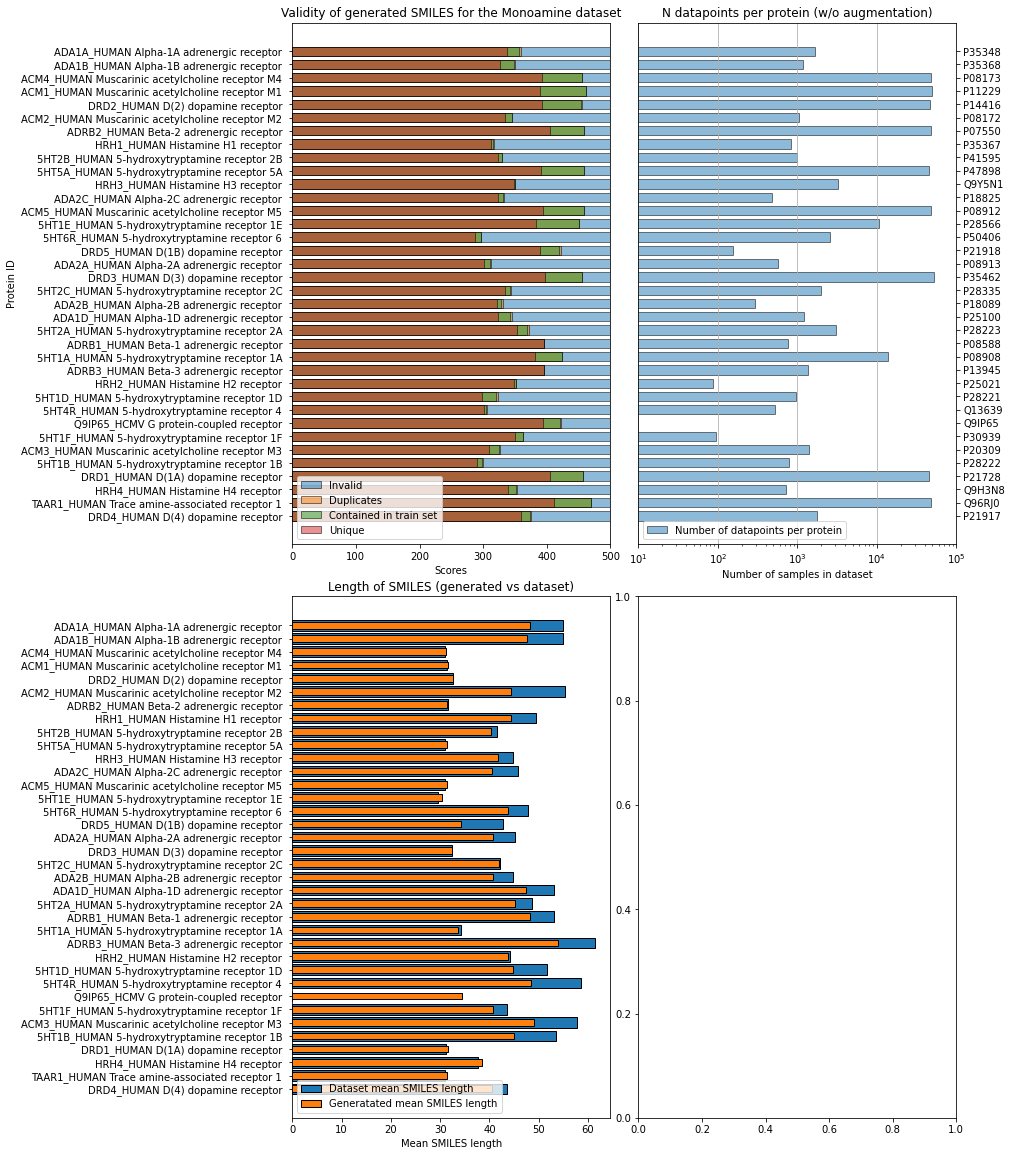

In [247]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,16)

fig, [[ax, ax2], [ax3, ax4]] = plt.subplots(2, 2)
labels = target_proteins
width = 0.7
alpha = 0.5

# print(len(list(difference)), len(valid_percentages))
# print(valid_percentages[0], n_canonized_non_dupes[0], differences[0])
valid = [v * 500 for v in valid_percentages]
total = [500 for _ in range(len(valid))]

## 1 ##
ax.barh(names, total, width, label='Invalid', alpha=alpha, edgecolor='k')
ax.barh(names, valid, width, label='Duplicates', alpha=alpha, edgecolor='k')
ax.barh(names, n_canonized_non_dupes, width, label='Contained in train set', alpha=alpha, edgecolor='k')
ax.barh(names, differences, width, label='Unique', alpha=alpha, edgecolor='k')
ax.set_xlabel('Scores')
ax.set_ylabel('Protein ID')
ax.set_xlim(0, 500)
ax.set_title('Validity of generated SMILES for the Monoamine dataset')
ax.legend(loc='lower left')

## 2 ##
ax2.barh(labels, num_datapoints, width, label='Number of datapoints per protein', alpha=0.5, edgecolor='k')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlabel('Number of samples in dataset')
ax2.set_xscale('log')
ax2.set_xlim(10e0, 10e4)
ax2.grid(axis='x')
ax2.set_title('N datapoints per protein (w/o augmentation)')
ax2.legend(loc='lower left')

## 3 ##
ax3.barh(names, data_mean_l, 0.8, label='Dataset mean SMILES length', alpha=1, edgecolor='k')
ax3.barh(names, mean_l, width-0.2, label='Generatated mean SMILES length', alpha=1, edgecolor='k')

ax3.set_xlabel('Mean SMILES length')
ax3.set_title('Length of SMILES (generated vs dataset)')
ax3.legend(loc='lower left')


print(labels)
fig.tight_layout(pad=0.5)
plt.show()


top_targets = ['Q96RJ0', 'P21728', 'P35462', 'P08912', 'P47898', 'P07550', 'P14416', 'P11229', 'P08173']

In [236]:
print(proteins[0].info)
print(proteins[0].seq)

>sp|P21917|DRD4_HUMAN D(4) dopamine receptor OS=Homo sapiens OX=9606 GN=DRD4 PE=1 SV=3

MGNRSTADADGLLAGRGPAAGASAGASAGLAGQGAAALVGGVLLIGAVLAGNSLVCVSVATERALQTPTNSFIVSLAAADLLLALLVLPLFVYSEVQGGAWLLSPRLCDALMAMDVMLCTASIFNLCAISVDRFVAVAVPLRYNRQGGSRRQLLLIGATWLLSAAVAAPVLCGLNDVRGRDPAVCRLEDRDYVVYSSVCSFFLPCPLMLLLYWATFRGLQRWEVARRAKLHGRAPRRPSGPGPPSPTPPAPRLPQDPCGPDCAPPAPGLPRGPCGPDCAPAAPSLPQDPCGPDCAPPAPGLPPDPCGSNCAPPDAVRAAALPPQTPPQTRRRRRAKITGRERKAMRVLPVVVGAFLLCWTPFFVVHITQALCPACSVPPRLVSAVTWLGYVNSALNPVIYTVFNAEFRNVFRKALRACC


In [282]:
## Centroids
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

# target_proteins.remove('Q9IP65')
# target_proteins.remove('Q9Y5N1')

fp_gen_centroid = {}
fps = []
for protein in target_proteins:
    print(protein)
    smiles_gen = non_duplicate_canonized[protein]
    smiles_dat = protein_smiles_dict[protein]
    mol_gen = [Chem.MolFromSmiles(smile) for smile in smiles_gen]
    fp_raw = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in mol_gen]
    fps += [fp_raw]
    print(len(fp_raw))
    

n = len(target_proteins)  
Centroid_dists = np.zeros([n, n])
for k in range(n):
    for l in range(n):
        d1 = len(fps[k])
        d2 = len(fps[l])
        D = np.zeros([d1, d2])
        for i in range(d1):
            for j in range(d2):
                sim = DataStructs.TanimotoSimilarity(fps[k][i], fps[l][j])
                D[i, j] = sim

        mean = np.mean(D)            
        Centroid_dists[k, l] = mean
        print(k, l, mean)
        
    

#     fp_dat = [AllChem.GetMorganFingerprint(mol, 2) for mol in mol_dat]
    
#     m1 = Chem.MolFromSmiles('Cc1ccccc1')
# >>> fp1 = AllChem.GetMorganFingerprint(m1,2)

P21917
373
Q96RJ0
469
Q9H3N8
351
P21728
457
P28222
299
P20309
325
P30939
362
Q13639
304
P28221
320
P25021
352
P13945
396
P08908
424
P08588
396
P28223
369
P25100
342
P18089
328
P28335
343
P35462
455
P08913
311
P21918
420
P50406
297
P28566
450
P08912
458
P18825
332
P47898
458
P41595
330
P35367
316
P07550
459
P08172
346
P14416
454
P11229
461
P08173
455
P35368
349
P35348
357
0.17611647988891246
0.11555575452000828
0.1328100160740888
0.1155799249921359
0.1481781084904485
0.13640411213529927
0.14777272045467574
0.1506705823758212
0.14464017972605
0.14762763095401607
0.12605754153997079
0.1254057285995592
0.12892692672664488
0.15877624768154486
0.1659596765563334
0.14576186350473477
0.1503666019994619
0.11673556528929785
0.14315434330947754
0.13614127223866426
0.13600143105056295
0.11798322058597295
0.11777508534720522
0.14438216474698118
0.11475431198857541
0.14684441180893212
0.15315098033394392
0.1156364220527284
0.13936204439051342
0.11951292600554858
0.11549063124067958
0.116760116521610

0.12096376295317793
0.11824388408864903
0.1191801595042892
0.11825059502243579
0.12258997400454302
0.12050739622966354
0.11966421771503134
0.12068135629841585
0.1195610762449393
0.12056763447906411
0.12548422956031022
0.1270931358695087
0.12892692672664488
0.11775200980629923
0.11555534229469772
0.11760617877786385
0.1233572682867798
0.1279686561452613
0.12656252843382268
0.13513756313763248
0.12234758967954865
0.13031223698867916
0.18041397041106705
0.12079262022499952
0.17209847132624465
0.12589225988962768
0.1308928916584266
0.12526994042710562
0.12106083308442539
0.11887937163927846
0.12180628413550716
0.12343282977570365
0.11812068591868669
0.11990855039247666
0.12113792495084343
0.12294550505485191
0.11790429030310198
0.12131186667246234
0.1278164653754458
0.12116180283389984
0.1255871975659374
0.12134619812197675
0.1185270876097095
0.11972506316937583
0.12925506430928785
0.1316249305206833
0.15877624768154483
0.11345210881545315
0.13128673833734436
0.11372909701237918
0.14571342

0.1136422019996962
0.11103953405940252
0.11189547759748161
0.1449188198208471
0.14568337147996493
0.11475431198857541
0.1200093284985826
0.10672649510210618
0.11956603198609994
0.10882836230443463
0.11001271277654984
0.11640349557095317
0.11840351781751308
0.10866157692127296
0.11510350191892646
0.11904178061834812
0.11918015950428922
0.11790429030310201
0.11301882283984555
0.11478837358968308
0.11235188993081517
0.11033818406389995
0.12000208260099625
0.11021936924202551
0.11724389933438219
0.1090024475504682
0.12103045350948831
0.12219405652709239
0.11015921033248843
0.12255434748160898
0.11052154036621849
0.11393097985560875
0.12217046548257156
0.11291694304556572
0.12122529006568265
0.120780268535197
0.12161145056963851
0.1137853533484255
0.11614944323583469
0.14684441180893212
0.11118524280076035
0.12571892252569297
0.11109887573791813
0.1384177222754043
0.1274079080122967
0.13654456961775466
0.1400733988384901
0.13540390078961112
0.13564108023965477
0.11846927742920466
0.11825059

In [284]:
import seaborn

<AxesSubplot:>

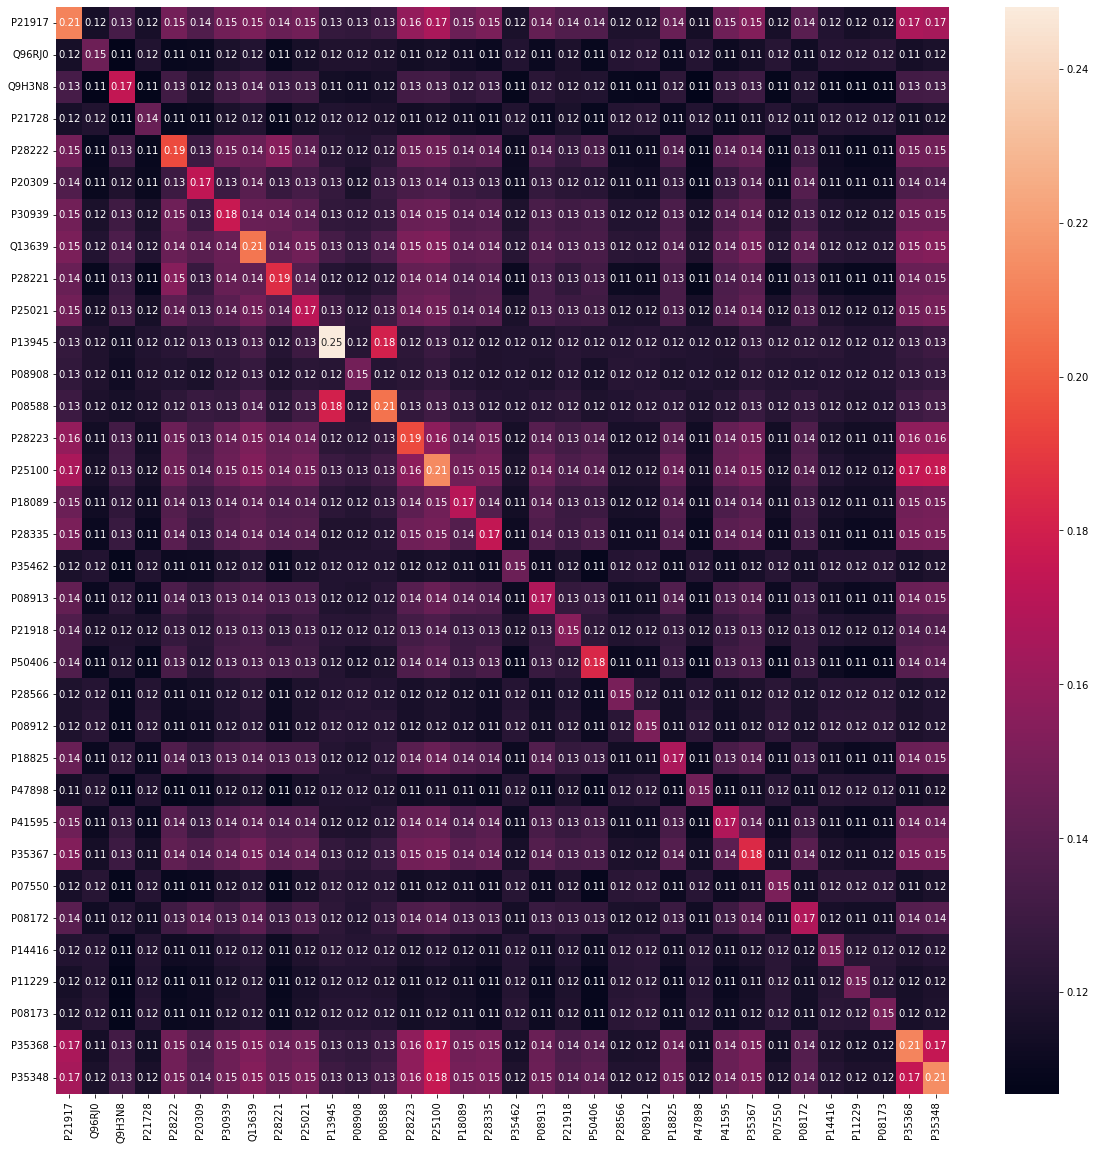

In [296]:
import seaborn as sn
import pandas as pd
import copy

c2 = copy.deepcopy(Centroid_dists)
for i in range(len(c2)):
    c2[i, i] = c2[i, i] * 1.2

df_cm = pd.DataFrame(c2, target_proteins,
                  columns = target_proteins)
plt.figure(figsize = (20,20))
sn.heatmap(df_cm, annot=True)